# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [5]:
import torch
torch.manual_seed(0)    #Setting random seed
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import random
random.seed(0)          #Setting random seed

import sys
from collections import deque, namedtuple


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size 
UPDATE_EVERY = 4        # how often to update the network

#Device type (use cuda if gpu is available else cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    
    """
    Defines the neural network architecture
    that will be used by the agent
    
    """
    
    
    def __init__(self, nA, nS, 
                 hidden_neurons = [64, 64], dropout = 0.1, seed = 0):
        
        """
        Arguments: nA [Int] (Number of Actions),
                   nS [Int] (State size),
                   hidden_neurons [List] (Neurons in each hidden layer),
                   dropout [Float from 0 to 1] (Dropout Regularization),
                   seed [Int] (random seed)
                   
        For example,
        
        dqn = DQN (nA = 2,
                   nS = 3, 
                   hidden_neuron = [8,16],
                   dropout = 0.1,
                   seed = 0)
                   
        This will create a model object which will have
        4 layers: the input layer with 3 neurons; next one hidden layer
        with 8 neurons; next another hidden layer with 16 neurons; final
        output layer with 2 neurons.The number of hidden layers and neurons
        in each layer is derived from the length of the list and corresponding
        elements respectively. Except the last layer each layer uses relu as 
        activation and dropout regularization.
        
        
        """
        
        
        super().__init__()
        
        
        # List of number neurons in each layer
        neurons = [nS, *hidden_neurons, nA]
        
        # Setting seed for reproducibility
        self.seed = torch.manual_seed(seed)
        
        # Creating sequence of linear layers
        # that will be applied to input
        self.layers = nn.ModuleList([nn.Linear(in_f, out_f) 
                                     for in_f,out_f in zip(neurons, neurons[1:])])
        
        # Dropout value
        self.dropout = dropout
    
        
    def forward(self,x):
        
        """
        Arguments: x [Torch Tensor] (input i.e. states)
        
        Returns: Q value for each action
        
        """
        
        
        # Passing the input through the linear 
        # layers with activations and dropout
        # except the last layer
        
        for i,layer in enumerate(self.layers):
            
            x = layer(x)
            
            if i!=len(self.layers)-1:
                
                x=nn.ReLU()(x)
                
                x=nn.Dropout(p=self.dropout)(x)
                
        return x
    

class Agent():
    
    """
    Defines the DQN Agent

    """
    
    
    def __init__(self, action_size, state_size, hidden_neurons,
                 double_dqn=False, dropout = 0.1,
                 gamma = 0.99, learning_rate = 1e-4, seed = 0, tau = 1e-3):
        
        """
        Arguments: action_size [Int] (Number of Actions),
                   state_size [Int] (State size),
                   hidden_neurons [List] (Neurons in each hidden layer),
                   double_dqn [Bool] (If true uses Double DQN else
                   general DQN),
                   dropout [Float from 0 to 1] (Dropout Regularization),
                   gamma [Float 0 to 1] (Discounting factor),
                   learning_rate [Float 0 to 1] (Learning rate for weight update),
                   seed [Int] (random seed),
                   tau [Float from 0 to 1] (Soft update rate for target DQN)
                   
                
        """
        
        
        self.nA = action_size
        self.nS = state_size
        
        self.seed = random.seed(seed)
        
        
        #Initializing main DQN
        self.main_network = DQN(action_size, 
                                state_size,
                                hidden_neurons,
                                dropout,
                                seed).to(device)
        
        #Initializing target DQN
        self.target_network = DQN(action_size, 
                                  state_size,
                                  hidden_neurons,
                                  dropout,
                                  seed).to(device)
        
        #Using ADAM Optimizer for main DQN         
        self.optimizer = optim.Adam(self.main_network.parameters(),
                                    lr=learning_rate)
        
        
        self.double_dqn = double_dqn
        
        
        self.gamma = gamma
        
        self.tau = tau
        
        #Time Step needed for update
        self.t_step = 0.
        
        #Initializing Replay Buffer
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        
        
    def act(self, state, eps):
        
        """
        Arguments: state [Torch Tensor] (environment state),
                   eps [Float from 0 to 1] (epsilon for epsilon-greedy)
                   
        Returns: Actions [Numpy Array]
        
        """
        
        
        # Setting the network to evaluation mode
        self.main_network.eval()
        
        # Using torch no grad as action selection
        # doesn't require gradients for DQN as it is
        # off-policy method
        with torch.no_grad():
        
            # Using epsilon-greedy to select actions
            # if random number (0 to 1) is greater than eps
            # selecting action using max network Q value output
            # else selecting actions randomly
            if random.random() > eps:
                
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)

                action =  np.argmax(self.main_network(state).cpu().data.numpy())
                                     
            else:

                action = np.random.randint(0,self.nA)
                
        
        # Setting model for training
        self.main_network.train()
        
        
        return action
    
    
    
    def learn(self,experiences, eps):
        
        """
        Arguments: experience [Tuple]( tuple containing sequence of 
                   state_t, action_t, reward_t, state_t+1, and 
                   each being a Torch Tensor)
                   
                   eps [Float from 0 to 1] (epsilon for epsilon-greedy)
        
        """
        
        # Experiences are fetched from Replay buffer
        states, actions, rewards, next_states, dones = experiences
        
        # Setting target network to evaluaion mode
        self.target_network.eval()
        
        with torch.no_grad():
            
            if self.double_dqn:
                
                # Using Double DQN 
                
                # Setting main network to evaluation mode
                self.main_network.eval()
                
                # Getting action with max Q value for next state 
                # using main network
                _, next_actions = torch.max(self.main_network(next_states),
                                             dim = 1,
                                             keepdim = True)
                
                
                # Getting Q value of next state from the target network 
                # using the action selected by the main network
                Q_next_state = (self.target_network(next_states)
                                .gather(dim = 1, index = next_actions))
            
            else:
                
                # Using Simple DQN
                
                # Getting action with max Q value for next state 
                # using target network
                Q_next_state, next_actions = torch.max(self.target_network(next_states),
                                             dim = 1,
                                             keepdim = True)

            
        self.main_network.train()
        
        # Calculating Temporal Difference Target
        Q_state = self.main_network(states).gather(dim=1, index = actions)
        
        TD_target = rewards + self.gamma * Q_next_state * (1-dones)
        
        # Using MSE Loss
        loss = F.mse_loss(Q_state, TD_target)
        
        # Zero grad removes any accumulated gradient
        self.optimizer.zero_grad()
        
        # Calculating gradients using backpropagation
        loss.backward()
        
        # Updating Weights
        self.optimizer.step()
        
        # Updating the target network using soft update through
        # weighted sum of previous parameters and current parameters
        self.soft_update(self.main_network, self.target_network)
        
    
    def soft_update(self, main_model, target_model):
        
        """
        Arguments: main_model [DQN object]
                   target_model [DQN object]
                   
        Description: updates the weight of the target model 
                     network using weighted sum of previous target model  
                     parameters and current main model parameters 

        """
        
        for target_param, main_param in zip(target_model.parameters(),
                                             main_model.parameters()):
            
            target_param.data.copy_(self.tau * main_param.data + (1.-self.tau) * target_param.data)
            
            
    def step(self,state, action, reward, next_state, done, eps):
        
        """
        Arguments: state [Numpy Array] (current state),
                   action [Numpy Array] (action taken at current state)
                   reward  (float) (reward received for current action)
                   next_state [Numpy Array] (next state as a result of current action)
                   done (Bool) (Whether episode has end or not)
                   eps (Float) (epsilon for epsilon-greedy)
        
        """
        
        # Adding experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Keeping track of time step
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # Updating model weights after 
        # regular intervals
        if self.t_step == 0:
            
            # Checking if enough samples are present
            if len(self.memory) > BATCH_SIZE:
                
                self.learn(self.memory.sample(), eps)
                
                
class ReplayBuffer():
    
    """
    Replay Buffer class
    
    """ 
    
    def __init__(self, buffer_size, batch_size, seed=0):
        
        """
        Arguments: buffer_size [Int] (max experience that will be stored,
                   past experiences will be deleted to store new ones),
                   batch_size [Int] (Batch Size for training)
        """
        
      
        # Memory for storing experiences
        self.memory = deque(maxlen = buffer_size)
        
        self.batch_size = batch_size
        
        self.seed = random.seed(seed)
        
        # Storing Experiences as named tuple
        self.experiences =  namedtuple('Experience', 
                                       ['state', 'action', 'reward', 'next_state', 'done'])
    
    
    def add(self, state, action, reward, next_state, done):
        
        """
        Arguments: state [Numpy Array] (current state),
                   action [Numpy Array] (action taken at current state)
                   reward  (float) (reward received for current action)
                   next_state [Numpy Array] (next state as a result of current action)
                   done (Bool) (Whether episode has end or not)
                   
        Description: Adds experience to memory
        
        """
        experience = self.experiences(state, action, reward, next_state, done)
        self.memory.append(experience)
        
        
    def sample(self):
        
        """
        Returns: Tuple of Torch Tensors containing
                 States, Actions, Rewards, Next States, Dones
                 of specified batch size
        
        """
        
        # Randomly sampling number of experiences equal to batch size
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Stacking the values and converting to tensors
        # to feed in batch
        
        states = (torch.from_numpy(np.vstack([e.state 
                                             for e in experiences if e is not None ]))
                  .float().to(device))
        
        actions = (torch.from_numpy(np.vstack([e.action
                                              for e in experiences if e is not None]))
                   .long().to(device))
        
        rewards = (torch.from_numpy(np.vstack([e.reward 
                                              for e in experiences if e is not None]))
                   .float().to(device))
        
        next_states = (torch.from_numpy(np.vstack([e.next_state 
                                                  for e in experiences if e is not None]))
                       .float().to(device))
                
        dones = (torch.from_numpy(np.vstack([e.done 
                                            for e in experiences if e is not None])
                                 .astype(np.uint8))
                    .float().to(device))
  
        return (states, actions, rewards, next_states, dones)
        
    
    def __len__(self):
        
        """
        Dunder Function to return
        length of memory
        
        """
        
        
        return len(self.memory)
                
        

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
# Initializing agent
agent = Agent(action_size, state_size, hidden_neurons = [64, 64], double_dqn= True)

In [7]:
episodes = 10000                   # Max no. of episodes
eps = 1.0                          # Starting Epsilon value
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)

for i_episode in range(1,episodes+1):
    
   
    eps /= i_episode  # Decaying epsilon
    
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0 

    steps = 0
    while True:
        
        action = agent.act(state, eps)                 # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  #see if episode has finished
        agent.step(state, action, reward, next_state, done, eps)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        
        steps+=1
            
            
        if done:                                       # exit loop if episode finished
            break

    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    sys.stdout.flush()
    
    if np.mean(scores_window) >= 13:
        
        torch.save({'main_network_state_dict':agent.main_network.state_dict(),
                    'target_network_state_dict':agent.target_network.state_dict(),
                    'optimizer_state_dict':agent.optimizer.state_dict()},
                    'agent_state_dict.pt')

        print("\n Problem Solved!")
        break
    
print("Score: {}".format(score))

env.close()

Episode 353	Average Score: 13.03
 Problem Solved!
Score: 14.0


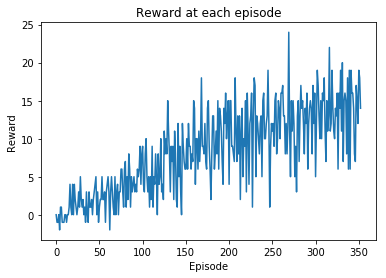

In [10]:
import matplotlib.pyplot as plt

plt.plot( scores )
plt.title("Reward at each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.savefig('reward_plot.png')
plt.show()